# Simple Monte Carlo Sampling of Foreground Halo Masses

In this notebook we use inference to get the distribution of halo masses for the individual halos in our background. First we explore probabilistic graphical model (PGM) and then we use monte carlo sampling to infer the halo mass posteriors.

## The PGM
For more an introduction to PGMS see Daphne Koller's [Probabilistic Graphical Models](http://pgm.stanford.edu/). Below is the PGM that we will explore in this notebook.

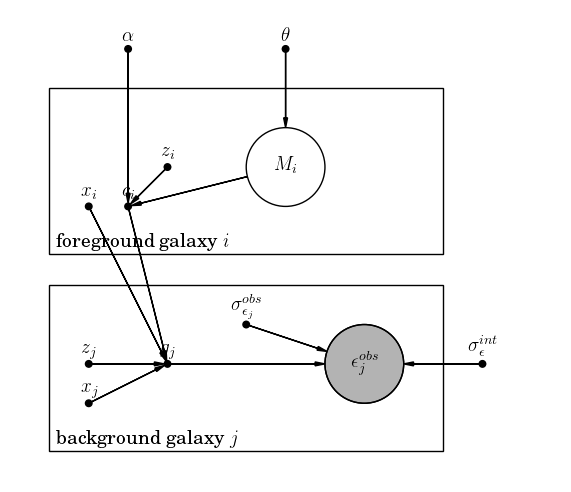

In [100]:
%matplotlib inline

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([7, 6], origin=[0, 0])

#background nodes
pgm.add_plate(daft.Plate([0.5, 3.0, 5, 2], label=r"foreground galaxy $i$",
    shift=-0.1))
pgm.add_node(daft.Node("theta", r"$\theta$", 3.5, 5.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.5, 5.5, fixed=True))
pgm.add_node(daft.Node("halo_mass", r"$M_i$", 3.5, 4, scale=2))
pgm.add_node(daft.Node("background_z", r"$z_i$", 2, 4, fixed=True))
pgm.add_node(daft.Node("concentration", r"$c_i$", 1.5, 3.5, fixed=True))
pgm.add_node(daft.Node("background_x", r"$x_i$", 1.0, 3.5, fixed=True))

#foreground nodes
pgm.add_plate(daft.Plate([0.5, 0.5, 5, 2], label=r"background galaxy $j$",
    shift=-0.1))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_z", r"$z_j$", 1.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_x", r"$x_j$", 1.0, 1.0, fixed=True))
pgm.add_node(daft.Node("ellipticities", r"$\epsilon_j^{obs}$", 4.5, 1.5, observed=True, scale=2))

#outer nodes
pgm.add_node(daft.Node("sigma_obs", r"$\sigma_{\epsilon_j}^{obs}$", 3.0, 2.0, fixed=True))
pgm.add_node(daft.Node("sigma_int", r"$\sigma_{\epsilon}^{int}$", 6.0, 1.5, fixed=True))

#edges
pgm.add_edge("foreground_z", "reduced_shear")
pgm.add_edge("foreground_x", "reduced_shear")
pgm.add_edge("reduced_shear", "ellipticities")
pgm.add_edge("sigma_obs", "ellipticities")
pgm.add_edge("sigma_int", "ellipticities")
pgm.add_edge("concentration", "reduced_shear")
pgm.add_edge("halo_mass", "concentration")
pgm.add_edge("background_z", "concentration")
pgm.add_edge("background_x", "reduced_shear")
pgm.add_edge("alpha", "concentration")
pgm.add_edge("theta", "halo_mass")
pgm.render()

We have sets of foregrounds and backgrounds along with the variables

- $\alpha$:  parameters in the concentration function (which is a function of $z_i,M_i$)
- $\theta$: prior distribution of halo masses
- $z_i$: foreground galaxy redshift
- $x_i$: foreground galaxy angular coordinates
- $z_j$: background galaxy redshift
- $x_j$: background galaxy angular coordinates
- $g_j$: reduced shear
- $\sigma_{\epsilon_j}^{obs}$: noise from our ellipticity measurement process
- $\sigma_{\epsilon}^{int}$: intrinsic variance in ellipticities
- $\epsilon_j^{obs}$: intrinsic variance in ellipticities

## Inference
We use monte carlo to generate many samples of our posterior

In [5]:
%load_ext autoreload
%autoreload 2

from pangloss import data, BackgroundCatalog, Configuration, ForegroundCatalog, \
    TrueHaloMassDistribution
from pandas import DataFrame

# initialize background and foreground
B = BackgroundCatalog(N=10.0, domain=[1.43, 1.4, -1.43, -1.4], field=[0, 0, 0, 0])
config = Configuration.example()
F = ForegroundCatalog(data.guo_file, config)
F.set_mass_prior(TrueHaloMassDistribution())

# run monte carlo samples
output = DataFrame()
for _ in range(5):
    F.draw_halo_masses()
    B.drill_lightcones(radius=1.0, foreground=F, save=False, smooth_corr=True)
    B.lens_by_halos(relevance_lim=0.00001, lookup_table=True, smooth_corr=True)
    halos = B.get_sampled_halo_masses_in_lightcones()
    halos['log-likelihood'] = B.calculate_log_likelihood()
    output = output.append(halos, ignore_index=True)

# galaxies that were filtered due to relevance should be assigned mass of 0
output = output.fillna(0)
output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/Users/user/Code/Pangloss/calib/Millennium/catalog_example.txt']
['/Users/user/Code/Pangloss/calib/Millennium/GGL_los*.fits']


,1.8001242e+13,1.80012420005e+13,1.80012420012e+13,1.80012420013e+13,1.80012420014e+13,1.8001242002e+13,1.80012420021e+13,1.8002097e+13,1.80022480001e+13,1.8005715e+13,...,4.97003629001e+14,4.97004515e+14,4.97011203e+14,5.00023445e+14,5.00025485e+14,5.01010108004e+14,5.01030332e+14,5.07000944e+14,5.07003892e+14,log-likelihood
0,6.024600e+10,2.685250e+11,3.450370e+12,0.000000e+00,1.148120e+12,2.319470e+12,1.704100e+11,1.497540e+12,6.368860e+10,4.785250e+11,...,8.176240e+10,0.000000e+00,1.420080e+11,0.000000e+00,1.841810e+11,8.348370e+10,1.540580e+11,0.000000e+00,0.000000e+00,13.048730
1,9.381160e+10,3.072550e+11,7.220910e+11,0.000000e+00,0.000000e+00,5.663120e+11,3.270500e+10,4.354920e+11,1.945080e+11,3.709430e+11,...,5.783620e+11,0.000000e+00,1.179100e+11,2.487300e+11,1.919270e+11,1.470860e+12,6.454930e+10,0.000000e+00,0.000000e+00,12.808623
2,0.000000e+00,1.368440e+11,1.549180e+11,2.151640e+11,0.000000e+00,0.000000e+00,1.342620e+11,0.000000e+00,0.000000e+00,1.659350e+12,...,7.289770e+11,0.000000e+00,3.614760e+10,1.003530e+12,9.363950e+11,4.991810e+10,1.256560e+11,0.000000e+00,9.458620e+11,12.580754
3,1.342620e+11,0.000000e+00,1.540580e+11,0.000000e+00,0.000000e+00,9.140180e+11,0.000000e+00,0.000000e+00,3.855740e+11,5.938530e+10,...,2.272130e+11,3.838530e+11,6.282800e+10,3.649190e+11,1.729920e+11,3.046730e+11,2.297950e+11,0.000000e+00,0.000000e+00,12.822688
4,5.258610e+11,1.635250e+11,9.553290e+10,3.287710e+11,0.000000e+00,0.000000e+00,2.005330e+11,0.000000e+00,7.969680e+11,7.229520e+10,...,8.778700e+10,0.000000e+00,2.134430e+11,3.718040e+11,1.428690e+11,9.122960e+10,6.110660e+11,1.609430e+12,0.000000e+00,12.771867


In [6]:
B.get_true_halo_masses_in_lightcones()

,1.8001242e+13,1.80012420005e+13,1.80012420012e+13,1.80012420013e+13,1.80012420021e+13,1.80022480001e+13,1.8005715e+13,1.8007889e+13,2.8000156e+13,2.80001560004e+13,...,4.97000377e+14,4.97003629e+14,4.97003629001e+14,4.97003629001e+14,4.97011203e+14,5.00023445e+14,5.00025485e+14,5.01010108004e+14,5.01030332e+14,5.07000944e+14
0,4.839470e+12,1.825450e+12,1.144670e+11,4.303290e+10,4.733610e+10,2.272130e+11,1.024180e+11,8.176240e+10,2.526030e+12,2.668040e+10,...,1.136070e+11,2.616400e+12,4.045090e+10,4.045090e+10,6.885260e+10,2.065580e+10,2.409840e+10,1.979510e+10,2.065580e+10,2.211890e+11


## Performance Benchmark

coming soon ...